In [1]:
%matplotlib inline
# %config InlineBackend.figure_formats = ['svg']

import imp
import innvestigate
import innvestigate.applications
import keras.backend
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import time
import keras
import re
import numpy as np
import sys

from string import punctuation
from keras.models import Model, load_model
from keras import optimizers
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from matplotlib import cm, transforms
from imblearn.metrics import classification_report_imbalanced
from innvestigate.utils.tests.networks import base as network_base
from sklearn.metrics import roc_curve, auc, confusion_matrix

sys.path.append("..")
from eventepi.pipeline import RecommenderLabeling

Using TensorFlow backend.


# Introduction

In this example, we are going to build a text classifer, inspired by experiments in [Arras et al. (2017a)][arras] and [Arras et al. (2017b)][arras2]. In particular, we are going to classify the relevance of epidemiological texts, and apply explanation methods provided by iNNvestigate to analyze how words in each article influence the articles's relevance prediction.

We apply various explanation methods implemented in iNNvestigate to explain decisions from a trained model. The figure below is explanations of a review that we expect to see: red indicates a high relevance score in favour of the prediction, while blue is the opposite.

![][sample]

[arras]: http://www.aclweb.org/anthology/W16-1601
[arras2]: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181142
[sample]: https://i.imgur.com/IRQL5oh.png

## Data Preprocessing

In [6]:
np.random.seed(13353)

In [7]:
wv = KeyedVectors.load("self_trained_200", mmap="r")
vocabs = [i for i in wv.wv.vocab.keys()] 
total_vocabs = len(vocabs) 

c:\users\abbooda\appdata\local\continuum\anaconda3\envs\rki\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [8]:
# Unknown vocabs are set to <UNK>.
encoder = dict(zip(['<UNK>'] + vocabs, range(len(vocabs) +1)))
decoder = dict(zip(encoder.values(), encoder.keys()))

print('We have %d vocabs.' % len(encoder))

We have 1534827 vocabs.


In [9]:
pretrained_embedding = wv.wv.vectors

# Unknown vocabs will have embedding weights of zero.
embedding = np.zeros((pretrained_embedding.shape[0]+1, pretrained_embedding.shape[1]))
embedding[1:, :] = pretrained_embedding

## Spiting Training, Testing, and Validation Set.

In [10]:
SPLIT_LABEL_MAPPING = {
    'training' : 1,
    'testing': 2,
    'validation': 3
}

MAX_SEQ_LENGTH = 200 # Calculated from where 63 is the shortest found text: min(epi_df.tokenized.apply(len))
EMBEDDING_DIM = embedding.shape[1]

In [11]:
epi_texts = RecommenderLabeling().data_output()

In [12]:
epi_texts["extracted_text"] = (epi_texts["extracted_text"]
                               .apply(lambda x: 
                                          re.sub(r"([0-9a-zA-Z]+)\.([A-Za-z]+\s)",
                                                 r"\g<1>. \g<2>",
                                                 x)
                                      )
                              )

In [13]:
print(f"There are {len(epi_texts)} text in total. {sum(epi_texts['label'])} of them are labeld as relevant")

There are 3232 text in total. 160 of them are labeld as relevant


In [14]:
# sent_tokenizer = PunktSentenceTokenizer(" ".join(epi_texts["extracted_text"]))
# with open("sent_tokenizer.p", "wb") as f:
#     pickle.dump(sent_tokenizer, f)

In [15]:
with open("sent_tokenizer.p", "rb") as f:
    sent_tokenizer = pickle.load(f)

In [16]:
epi_texts['tokenized'] = (epi_texts["extracted_text"]
                          .apply(lambda x: sent_tokenizer.tokenize(x))
                          .apply(lambda x: [word_tokenize(sentence) for sentence in x])
                          .apply(lambda article: [token for sentence in article for token in sentence])
                         )

In [17]:
epi_texts["tokenized"] = (epi_texts["tokenized"]
                               .apply(lambda x: [i.lower() for i in x if i not in punctuation])
                              )

In [19]:
print(f"{sum(epi_texts['tokenized'].apply(len) < 200)} documents are padded since they are shorter than {MAX_SEQ_LENGTH} token")

89 documents are padded since they are shorter than 200 token


In [24]:
train, validate, test = np.split(epi_texts.sample(frac=1), [int(.6*len(epi_texts)), int(.8*len(epi_texts))], )

In [18]:
train["splitset_label"] = "training"

In [19]:
validate["splitset_label"] = "validation"

In [20]:
test["splitset_label"] = "testing"

In [21]:
validate["splitset_label"] = "validation"

In [22]:
epi_df = pd.concat([train, test, validate])

In [23]:
epi_df.head()

,extracted_text,label,tokenized,splitset_label
1752,Outbreak 1: Haixi Mongolian and Tibetan Autono...,False,"[outbreak, 1, haixi, mongolian, and, tibetan, ...",training
2338,ProMED-mail from HealthMap alerts <promed@prom...,False,"[promed-mail, from, healthmap, alerts, promed,...",training
1176,"[2] Spread, control measures, map Date: Sat 25...",False,"[2, spread, control, measures, map, date, sat,...",training
1838,ProMED-mail is a program of the International ...,False,"[promed-mail, is, a, program, of, the, interna...",training
85,Disease Outbreak News 19 February 2018 On 27 O...,False,"[disease, outbreak, news, 19, february, 2018, ...",training


In [24]:
LABEL_IDX_TO_NAME = {
    0: 'irrelevant',
    1: 'relevant'
}

In [25]:
def prepare_own_dataset(data_set):
    filtered_indices = epi_df["splitset_label"] == data_set
    data_set_of_epi_df = epi_df[filtered_indices]
    
    xd = np.zeros((len(data_set_of_epi_df), MAX_SEQ_LENGTH, EMBEDDING_DIM))
    y = data_set_of_epi_df["label"].values.astype(int)
    
    articles = []
    for i, tokenized in enumerate(data_set_of_epi_df["tokenized"].values):
        tokenized = [token.lower() for token in tokenized]
        article = []
        for j, v in enumerate(tokenized[:MAX_SEQ_LENGTH]):
            if v in encoder:
                e_idx = encoder[v]
            else:
                e_idx = 0
            
            xd[i, j, :] = embedding[e_idx]
            article.append(e_idx)
        articles.append(article)
    
    return dict(x4d=np.expand_dims(xd, axis=1), 
                y=y,
                encoded_articles=articles)

DATASETS = dict()

for data_set in ['training', 'testing', 'validation']:
    DATASETS[data_set] = prepare_own_dataset(data_set)

In [26]:
# Find text with lowest amount of <UNK> tokens
ideces_of_lowest = []
length = 4
while len(ideces_of_lowest) < 1:
    for sample_idx in range(len(DATASETS['testing']['encoded_articles'])):
        text = ' '.join(map(lambda x: decoder[x], DATASETS['training']['encoded_articles'][sample_idx]))
        amount_of_unk = len(re.findall(r"<UNK>", text))
        if amount_of_unk == length:
            ideces_of_lowest.append(sample_idx)
    length += 1

In [27]:
print('Review(ID=%d): %s' %
      (sample_idx, ' '.join(map(lambda x: decoder[x], DATASETS['training']['encoded_articles'][590]))))

Review(ID=646): e. coli ehec usa 22 wa restaurants <UNK> e. coli ehec usa 21 tn o157 2 clusters 2 sources <UNK> e. coli ehec usa 20 o157 romaine lettuce water source <UNK> e. coli ehec usa 19 ut az o157 2017 <UNK> e. coli ehec usa 18 tn raw milk more cases <UNK> e. coli ehec usa 17 or o111 daycare center <UNK> e. coli ehec usa 16 tn raw milk <UNK> e. coli ehec usa 15 o157 romaine lettuce more cases fatal <UNK> e. coli ehec usa 14 wa sandwich shops 20180527.5820803 e. coli ehec usa 13 o157 romaine lettuce increasing cases fatality 20180517.5799620 e. coli ehec usa 12 o157 romaine lettuce increasing cases fatality 20180510.5791677 e. coli ehec usa 11 ok day care center 20180502.5780250 e. coli ehec usa 10 o157 romaine lettuce fatality 20180502.5780249 e. coli ehec usa 09 o157 romaine lettuce 20180427.5771229 e. coli ehec usa 08 ca military outbreak undercooked beef 2017 20180425.5769489 e. coli ehec usa 07 o157 romaine lettuce 20180425.5769488 e. coli ehec usa 06 o157 romaine lettuce 201

# Model Construction

Our classifier is a convolutional neural network, which was inspired by the network used in https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181142

In [28]:
NUM_CLASSES = 2

In [59]:
def build_network(input_shape, output_n, activation=None, dense_unit=256, dropout_rate=0.25):
    if activation:
        activation = "relu"

    net = {}
    net["in"] = network_base.input_layer(shape=input_shape)
    
    net["conv"] = keras.layers.Conv2D(filters=100, kernel_size=(1,2), 
                                      strides=(1, 1),
                                      activation='relu', 
                                      padding='valid')(net["in"])
    net["dropout"] = keras.layers.Dropout(dropout_rate)(net["conv"])
    net["pool"] = keras.layers.MaxPooling2D(pool_size=(1, input_shape[2]-1), strides=(1,1))(net["dropout"])
    
    net["out"] = network_base.dense_layer(keras.layers.Flatten()(net["pool"]), units=output_n, activation=activation)
    net["sm_out"] = network_base.softmax(net["out"])


    net.update({
        "input_shape": input_shape,

        "output_n": output_n,
    })
    return net

net = build_network((None, 1, MAX_SEQ_LENGTH, EMBEDDING_DIM), NUM_CLASSES)
model_without_softmax, model_with_softmax = Model(inputs=net['in'], outputs=net['out']), Model(inputs=net['in'], outputs=net['sm_out'])

In [30]:
# def build_network(input_shape, output_n, activation=None, dense_unit=256, dropout_rate=0.25):
#     if activation:
#         activation = "relu"

#     net = {}
#     net["in"] = network_base.input_layer(shape=input_shape)
#     net["conv"] = keras.layers.Conv2D(filters=256, kernel_size=(1,2), 
#                                       strides=(1, 1),
#                                       activation='relu', 
#                                       padding='valid')(net["in"])
#     net["pool"] = keras.layers.MaxPooling2D(pool_size=(1, (input_shape[2]-3)// 5 ), strides=(1,1))(net["conv"])
#     net["flat"] = keras.layers.Reshape((1,int(net["pool"].shape[2]) * int(net["pool"].shape[3])))(net["pool"])
#     net["linear"] = keras.layers.Dense(128, activation=activation)(net["flat"])
#     net["dropout"] = keras.layers.Dropout(dropout_rate)(net["linear"])
#     net["out"] = network_base.dense_layer(keras.layers.Flatten()(net["dropout"]), units=output_n, activation=activation)
#     net["sm_out"] = network_base.softmax(net["out"])


#     net.update({
#         "input_shape": input_shape,

#         "output_n": output_n,
#     })
#     return net

# net = build_network((None, 1, MAX_SEQ_LENGTH, EMBEDDING_DIM), NUM_CLASSES)
# model_without_softmax, model_with_softmax = Model(inputs=net['in'], outputs=net['out']), Model(inputs=net['in'], outputs=net['sm_out'])

In [60]:
def to_one_hot(y):
    return keras.utils.to_categorical(y, NUM_CLASSES)

def train_model(model,  batch_size=200, epochs=40):
    
    x_train = DATASETS['training']['x4d']
    y_train = to_one_hot(DATASETS['training']['y'])
    
    x_test = DATASETS['testing']['x4d']
    y_test = to_one_hot(DATASETS['testing']['y'])
    
    x_val = DATASETS['validation']['x4d']
    y_val = to_one_hot(DATASETS['validation']['y'])
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val),
                        shuffle=True,
                        class_weight="auto"
                       )
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [61]:
train_model(model_with_softmax, batch_size=256, epochs=20)

Train on 1939 samples, validate on 646 samples
Epoch 1/20
1939/1939 [==============================] - ETA: 5s - loss: 1.0101 - acc: 0.125 - ETA: 3s - loss: 0.7780 - acc: 0.472 - ETA: 2s - loss: 0.6321 - acc: 0.632 - ETA: 2s - loss: 0.5455 - acc: 0.708 - ETA: 1s - loss: 0.4737 - acc: 0.757 - ETA: 0s - loss: 0.4348 - acc: 0.787 - ETA: 0s - loss: 0.4000 - acc: 0.811 - 5s 3ms/step - loss: 0.3797 - acc: 0.8241 - val_loss: 0.2018 - val_acc: 0.9505
Epoch 2/20
1939/1939 [==============================] - ETA: 4s - loss: 0.1402 - acc: 0.972 - ETA: 3s - loss: 0.1907 - acc: 0.962 - ETA: 2s - loss: 0.2242 - acc: 0.958 - ETA: 1s - loss: 0.2227 - acc: 0.959 - ETA: 1s - loss: 0.2384 - acc: 0.957 - ETA: 0s - loss: 0.2465 - acc: 0.955 - ETA: 0s - loss: 0.2641 - acc: 0.952 - 4s 2ms/step - loss: 0.2652 - acc: 0.9526 - val_loss: 0.2172 - val_acc: 0.9505
Epoch 3/20
1939/1939 [==============================] - ETA: 3s - loss: 0.2535 - acc: 0.957 - ETA: 2s - loss: 0.2458 - acc: 0.957 - ETA: 2s - loss: 0.262

In [62]:
model_without_softmax.set_weights(model_with_softmax.get_weights())

In [ ]:
model_with_softmax.save("my_model_softmax")
model_without_softmax.save("my_model_without_softmax")

In [67]:
model_with_softmax = load_model('my_model')
model_without_softmax = load_model('my_model_without')

c:\users\abbooda\appdata\local\continuum\anaconda3\envs\rki\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [68]:
x_test = DATASETS['testing']['x4d']
y_test = DATASETS['testing']['y']

soft_max_predicted = model_with_softmax.predict(x_test)
y_pred = [soft_max_predicted[i][1] for i in range(len(x_test))]

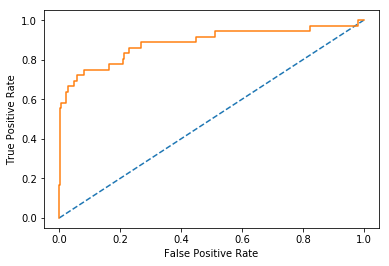

In [69]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

In [70]:
y_argmax = [soft_max_predicted[i].argmax() for i in range(len(x_test))]

In [71]:
print(classification_report_imbalanced(y_test, y_argmax))
print(confusion_matrix(y_test, y_argmax))
print('AUC score: {:3f}'.format(auc(fpr, tpr)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      1.00      0.14      0.98      0.37      0.15       611
          1       1.00      0.14      1.00      0.24      0.37      0.13        36

avg / total       0.95      0.95      0.19      0.93      0.37      0.15       647

[[611   0]
 [ 31   5]]
AUC score: 0.884979


# Model Analysis and Visualization

At this stage, we have a trained model and are ready to explain it via **iNNvestigate**'s analyzers.

In [30]:
# Specify methods that you would like to use to explain the model. 
# Please refer to iNNvestigate's documents for available methods.
methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'pattern.attribution']
kwargs = [{}, {}, {}, {'pattern_type': 'relu'}]

In [31]:
# build an analyzer for each method
analyzers = []

for method, kws in zip(methods, kwargs):
    analyzer = innvestigate.create_analyzer(method, model_without_softmax, **kws)
    analyzer.fit(DATASETS['training']['x4d'], batch_size=256, verbose=1)
    analyzers.append(analyzer)

c:\users\abbooda\appdata\local\continuum\anaconda3\envs\rki\lib\site-packages\innvestigate\analyzer\base.py:130: RuntimeWarning: This analyzer does not need to be trained. Still fit() is called.
  " Still fit() is called.", RuntimeWarning)


Epoch 1/1
8/8 [==============================] - 9s 1s/step - loss: 2.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000


In [32]:
# specify indices of reviews that we want to investigate
# test_sample_indices = [170, 321, 414]
test_sample_indices = np.argwhere(DATASETS['testing']['y']==1).squeeze()
test_sample_preds = [None]*len(test_sample_indices)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_indices), len(analyzers), 1, MAX_SEQ_LENGTH])

for i, ridx in enumerate(test_sample_indices):

    x, y = DATASETS['testing']['x4d'][ridx], DATASETS['testing']['y'][ridx]

    t_start = time.time()
    x = x.reshape((1, 1, MAX_SEQ_LENGTH, EMBEDDING_DIM))    

    presm = model_without_softmax.predict_on_batch(x)[0] #forward pass without softmax
    prob = model_with_softmax.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    test_sample_preds[i] = y_hat
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)

        analysis[i, aidx] = a
    t_elapsed = time.time() - t_start
    print('Review %d (%.4fs)'% (ridx, t_elapsed))

Review 10 (1.1730s)
Review 17 (0.0100s)
Review 55 (0.0090s)
Review 109 (0.0100s)
Review 132 (0.0100s)
Review 136 (0.0090s)
Review 138 (0.0090s)
Review 143 (0.0090s)
Review 162 (0.0090s)
Review 193 (0.0090s)
Review 194 (0.0090s)
Review 226 (0.0100s)
Review 227 (0.0110s)
Review 229 (0.0090s)
Review 315 (0.0080s)
Review 324 (0.0090s)
Review 383 (0.0090s)
Review 402 (0.0090s)
Review 404 (0.0090s)
Review 448 (0.0080s)
Review 457 (0.0090s)
Review 495 (0.0090s)
Review 497 (0.0120s)
Review 556 (0.0090s)
Review 611 (0.0130s)
Review 618 (0.0110s)
Review 633 (0.0090s)


## Visualization

To this point, we have all analysis results from iNNvestigate's analyzers, and we are now ready to visualize them in a insightful way. We will use relevance scores from explanation methods to highlight the words in each review. 

We will use  the *blue-white-red (bwr)* color map for this purpose. Hence, words that have a positive score to the prediction are be shaded in *red*, while  negative-contribution or zero-contribution words are then highlighted in *blue*, and *white*, respectively.


In [33]:
# This is a utility method visualizing the relevance scores of each word to the network's prediction. 
# one might skip understanding the function, and see its output first.
def plot_text_heatmap(words, name, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 0.5,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')
    if name:
        plt.savefig(name,  bbox_inches='tight')

Review(id=10): https <UNK> sources in the kingdom of saudi arabia reported that 6 people from one family were infected with the mers-cov the infection was diagnosed in najran in the south and the patients were transferred to riyadh according to the ministry of health sources told the local newspaper that the family 's home was examined by the health authorities in najran it was found that a family member and his household had symptoms of the infection a total of 6 individuals they were kept in a hospital in riyadh the source added that the family had a farm in najran with a number of camels the ministry of environment water and agriculture was directed to take preventive measures -- communicated by promed-mail rapporteur mary marshall this media report is the 1st information available on mers-cov in saudi arabia since the middle of may 2018 the last newly confirmed mers-cov infection was reported from tabuk on 13 may 2018 the most recent reported case from najran was on 12 apr 2018 a 4

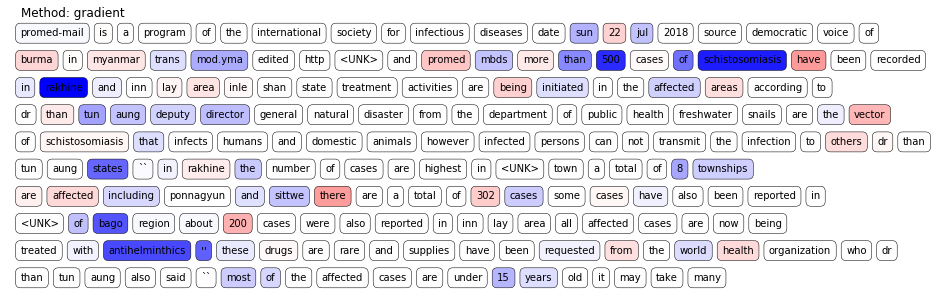

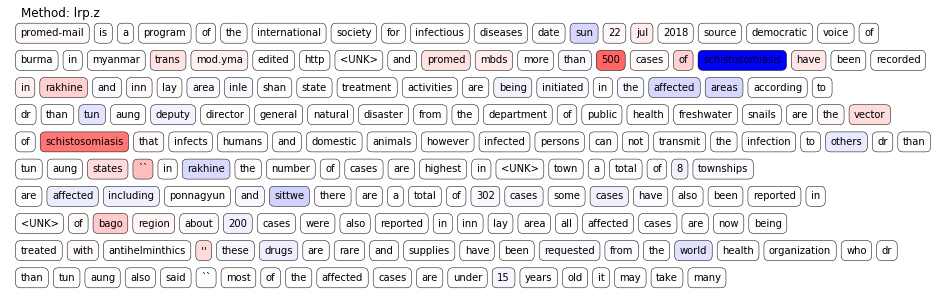

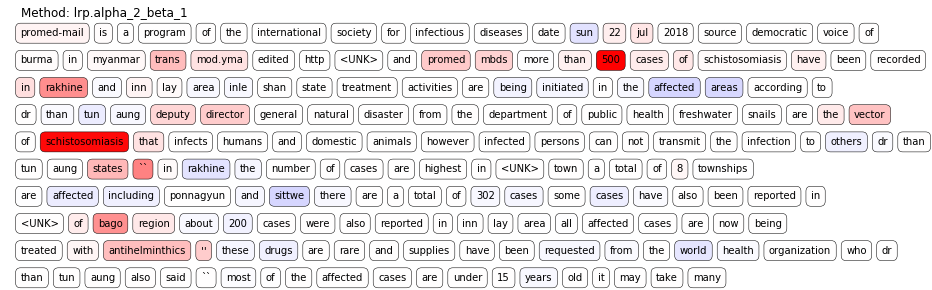

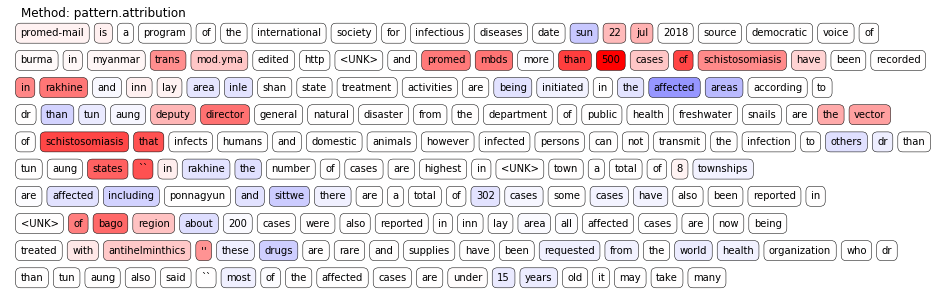

Review(id=143): promed-mail is a program of the international society for infectious diseases date tue 6 nov 2018 source ministry of health new zealand edited https <UNK> there has been a significant increase in _neisseria meningitidis_ serogroup w menw in new zealand since <UNK> between 1 jan 2017 and 31 dec 2017 there were 12 cases of menw reported including 3 deaths this number has doubled to date for 2018 with 24 cases reported so far as of 5 nov 2018 including 6 deaths prior to 2017 0 to 6 menw cases were reported each year the northland region has been the most affected in 2018 with 7 of the 24 cases reported in this region including 4 cases in september and october 2018 this particular strain of menw sequence type st11 affects all age groups and is associated with a high case-fatality rate menw can present with the classical signs of meningococcal disease but also atypically with gastrointestinal symptoms as well as pneumonia septic arthritis endocarditis or <UNK> menw was previ

In [36]:
# Traverse over the analysis results and visualize them.
for i, idx in enumerate(test_sample_indices):

    words = [decoder[t] for t in list(DATASETS['testing']['encoded_articles'][idx])]
    
    print('Review(id=%d): %s' % (idx, ' '.join(words)))
    y_true = DATASETS['testing']['y'][idx]
    y_pred = test_sample_preds[i]

    print("Pred class : %s %s" %
          (LABEL_IDX_TO_NAME[y_pred], '✓' if y_pred == y_true else '✗ (%s)' % LABEL_IDX_TO_NAME[y_true])
         )
                                
    for j, method in enumerate(methods):
        if y_pred == y_true:
            name = f"{i}_gradient_plot_{method}.pdf"
            plot_text_heatmap(words, name, analysis[i, j].reshape(-1), title='Method: %s' % method, verbose=0,)
            plt.show()
            name = None
        else: 
            name = None
